# Definition and importation of the variables $X$ and $Y$

Observational constrained enables to constrain the distribution of a future variable $X$, by using the observation of a given variable $X$. It is thus necessary to define $X$, $Y$, and import the $X$ and $Y$ values of climate models and the $X$ value observed.

This notebook imports and computes the $X$ and $Y$ values associated to different CMIP6 climate models, and the $X$ value observed from HadCRUT5.
In this example, $X$ is the global temperature averaged between 2015 and 2023. $Y$ is the global temperature averaged between 2091 and 2100.

The values and then saved, to be use in an example of observational constrain in the next notebook.

# Needed packages

In [1]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy.interpolate import LinearNDInterpolator


# Needed functions

In [2]:
def get_latitudes(ds):
    # Find the model variant variable name
    list_potential_var = ['latitude', 'lat','rlat', 'y','nav_lat']
    for var_name in list_potential_var:
        if(var_name in list(ds.variables)):
            ds_var = ds[var_name]
            return ds_var[:].data
    raise NameError("No variable called: {} among {}".format(list_potential_var, list(ds.variables)))
    
def get_longitudes(ds):
    # Find the model variant variable name
    list_potential_var = ['longitude', 'lon', 'nav_lon', 'x']
    for var_name in list_potential_var:
        if(var_name in list(ds.variables)):
            ds_var = ds[var_name]
            return ds_var[:].data
    raise NameError("No variable called: {} among {}".format(list_potential_var, list(ds.variables)))
        
def load_lat_lon_area(path):
    ds = nc.Dataset(path)
    latitudes = ds["lat"][:].data
    longitudes = ds["lon"][:].data
    area_perLat_per_Lon = ds["cell_area"][:].data
    return latitudes, longitudes, area_perLat_per_Lon
    

def interpolate(ds, temporal_mean_perLat_perLon,
                latitudes_1deg, longitudes_1deg):

    latitudes  = get_latitudes(ds)
    longitudes = get_longitudes(ds)
    longitudes[longitudes>180] -= 360 # transform latitude that goes from 0 to 360, to -180 to 180
    nb_lat, nb_lon = len(latitudes), len(longitudes)
    points = np.array(np.meshgrid(latitudes, longitudes)).T.reshape(nb_lat*nb_lon, 2)
    values = temporal_mean_perLat_perLon.flatten()
    interp = LinearNDInterpolator(points, values)
    temporal_mean_perLat_perLon_1deg = interp(np.array(np.meshgrid(latitudes_1deg, longitudes_1deg)).T)
    
    return temporal_mean_perLat_perLon_1deg



# Definition of X and Y as temporal means

In [ ]:
min_X = np.datetime64('2015') # 1851
max_X = np.datetime64('2023') # 2014
min_Y = np.datetime64('2091')
max_Y = np.datetime64('2100')

# FInd what scenario to take depending on the times chosen
if (max_X<=np.datetime64('2014')):
    experiment_id_X = 'historical'
elif (np.datetime64('2015')<=min_X):
    experiment_id_X = 'ssp245'
else:
    raise NameError("The period used to construct X is on two different scenarios")

# remark: it is possible to construct X if the time period considered is on both historical and ssp period, by concatenate both periods.
#         This is not done here, to simply the readability

# Compute the observed (real) value of X
Data from https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html

In [4]:
ds = nc.Dataset("../data/HadCRUT.5.0.2.0.analysis.ensemble_series.global.annual.nc")

# To get the absolute values from the anomalies relative to 1961-1990,
# I add 13.974, the 1961-1990 global average (https://crudata.uea.ac.uk/cru/data/temperature/)
tas_perRealisation_perTime = ds["tas"][:].data + 13.974


print("Temporal averaging")
# Get the time labels
time = ds["time"][:].data.astype("datetime64[D]")-np.datetime64('1970-01-01')+np.datetime64('1850-01-01')
time = time.astype("datetime64[Y]")
times_to_keep = np.logical_and(min_X<=time, time<=max_X)

# Time-averaging
mean_tas_perRealisation = np.nanmean(tas_perRealisation_perTime[:, times_to_keep], axis=1)

# Compute the observed value and its uncertainty, defined as the spread between realizations
X_obs = np.mean(mean_tas_perRealisation)
std_obs = np.std(mean_tas_perRealisation)
print("Observed {}-{} averaged global temperature: {:.2f} 째C +- {:.2f}".format(min_X, max_X, X_obs, std_obs))

# Save the computed values
np.save("../data/X_obs", X_obs)
np.save("../data/std_obs", std_obs)


Temporal averaging
Observed 2015-2023 averaged global temperature: 14.85 째C +- 0.01


# Compute X and Y for each climate model

## Import database

In [5]:
# The Pangeo CMIP6 URL.
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
# Open the catalog into a pandas DataFrame.
df = intake.open_esm_datastore(url)

## Define the climate models to import

In [6]:
# https://aims2.llnl.gov/search/cmip6/ to find models

list_models_to_test = []
list_models_to_test.append(["CAS-ESM2-0", "r1i1p1f1"])
list_models_to_test.append(["GFDL-ESM4", "r1i1p1f1"])
list_models_to_test.append(["CESM2", "r11i1p1f1"])
list_models_to_test.append(["CESM2-WACCM", "r1i1p1f1"])
list_models_to_test.append(["CNRM-CM6-1", "r1i1p1f2"])
list_models_to_test.append(["CNRM-CM6-1-HR", "r1i1p1f2"])
list_models_to_test.append(["CNRM-ESM2-1", "r1i1p1f2"])
list_models_to_test.append(["IPSL-CM6A-LR", "r1i1p1f1"])
list_models_to_test.append(["ACCESS-CM2", "r1i1p1f1"])
list_models_to_test.append(["ACCESS-ESM1-5", "r1i1p1f1"])
list_models_to_test.append(["CIESM", "r1i1p1f1"])
list_models_to_test.append(["CMCC-CM2-SR5", "r1i1p1f1"])
list_models_to_test.append(["CMCC-ESM2", "r1i1p1f1"])
list_models_to_test.append(["CanESM5", "r1i1p1f1"])
list_models_to_test.append(["CanESM5-CanOE", "r1i1p2f1"])
list_models_to_test.append(["EC-Earth3", "r2i1p1f1"])
list_models_to_test.append(["EC-Earth3-Veg", "r5i1p1f1"])
list_models_to_test.append(["EC-Earth3-CC", "r4i1p1f1"])
list_models_to_test.append(["FGOALS-f3-L", "r1i1p1f1"])
list_models_to_test.append(["FGOALS-g3", "r3i1p1f1"])
list_models_to_test.append(["GISS-E2-1-G", "r1i1p1f2"])
list_models_to_test.append(["GISS-E2-2-G", "r1i1p3f1"])
list_models_to_test.append(["HadGEM3-GC31-LL", "r1i1p1f3"])
list_models_to_test.append(["INM-CM4-8", "r1i1p1f1"])
list_models_to_test.append(["INM-CM5-0", "r1i1p1f1"])
list_models_to_test.append(["MIROC-ES2L", "r2i1p1f2"])
list_models_to_test.append(["MIROC6", "r1i1p1f1"])
list_models_to_test.append(["MPI-ESM1-2-HR", "r1i1p1f1"])
list_models_to_test.append(["MPI-ESM1-2-LR", "r1i1p1f1"])
list_models_to_test.append(["MRI-ESM2-0", "r1i1p1f1"])
list_models_to_test.append(["UKESM1-0-LL", "r1i1p1f2"])
list_models_to_test.append(["NorESM2-MM", "r1i1p1f1"])
list_models_to_test.append(["NorESM2-LM", "r2i1p1f1"])


In [7]:
len(list_models_to_test)

33

## Define the reference grid
To compute X and Y as global averages, we need the area for each grid point.

We use the given file that contains the area for each grid point, in a grid of resolution 360 longitudes by 180 latitudes (1 degree grid).

Then, we interpolate each climate model to this grid, to average it globaly.

In [8]:
latitudes_1deg, longitudes_1deg, area_perLat_perLon_1deg = load_lat_lon_area("../data/area_r360x180.nc")
longitudes_1deg[longitudes_1deg>180] -= 360 # transform latitude that goes from 0 to 360, to -180 to 180

## Compute X and Y for each climate model

In [9]:
#--------------------------------------- Construct X_mod and Y_mod
list_X = []
list_Y = []
list_models = []
list_runs = []
for model_to_test in list_models_to_test:
    model_name = model_to_test[0]
    model_run  = model_to_test[1]

    print("------------------------------------------- Try the model {}".format(model_name))
    try:
        print("\tImport model...")
        # Import historical period
        model_X = df.search(experiment_id=experiment_id_X,
                                      table_id='Amon',
                                      variable_id='tas',
                                      source_id=model_name,
                                      member_id=model_run)
        # Import SSP245 period
        model_ssp = df.search(experiment_id='ssp245',
                                      table_id='Amon',
                                      variable_id='tas',
                                      source_id=model_name,
                                      member_id=model_run)
        
        
        dataset_X = model_X.to_dataset_dict()
        dataset_ssp  = model_ssp.to_dataset_dict()
        ds_ssp  = dataset_ssp[list(dataset_ssp.keys())[0]]
        ds_X = dataset_X[list(dataset_X.keys())[0]]
        print("\tImport model ok")
        

        
        print("\tTemporal averaging...")
        # Get the time labels
        hist_times_yearly = ds_X['time'].data.astype("datetime64[Y]")
        ssp_times_yearly  = ds_ssp['time'].data.astype("datetime64[Y]")
        times_to_keep_X   = np.logical_and(min_X<=hist_times_yearly, hist_times_yearly<=max_X)
        times_to_keep_Y   = np.logical_and(min_Y<=ssp_times_yearly, ssp_times_yearly<=max_Y)
        # Averaging
        temporal_mean_perLat_perLon_X = np.nanmean(ds_X['tas'][0,0, times_to_keep_X], axis=0)
        temporal_mean_perLat_perLon_Y = np.nanmean(ds_ssp['tas'][0,0, times_to_keep_Y],  axis=0)
        print("\tTemporal averaging ok")
        
        
        print("\tSpatial averaging...")
        temporal_mean_perLat_perLon_X_1deg = interpolate(ds_X, temporal_mean_perLat_perLon_X,
                latitudes_1deg, longitudes_1deg)
        temporal_mean_perLat_perLon_Y_1deg = interpolate(ds_ssp, temporal_mean_perLat_perLon_Y,
                latitudes_1deg, longitudes_1deg)
        
        
        # Compute average (on not missing data)
        not_missing_indexesX = np.logical_not(np.isnan(temporal_mean_perLat_perLon_X_1deg))
        not_missing_indexesY = np.logical_not(np.isnan(temporal_mean_perLat_perLon_Y_1deg))
        X = np.average(temporal_mean_perLat_perLon_X_1deg[not_missing_indexesX].flatten(),
                       weights=area_perLat_perLon_1deg[not_missing_indexesX].flatten())
        
        Y = np.average(temporal_mean_perLat_perLon_Y_1deg[not_missing_indexesY].flatten(),
                       weights=area_perLat_perLon_1deg[not_missing_indexesY].flatten())
        
        print("\tSpatial averaging ok")

        print("\tX={:.2f}, Y={:.2f}".format(X,Y))
        
        # Storage
        list_X.append(X)
        list_Y.append(Y)
        list_models.append(model_name)
        list_runs.append(model_run)
        
    except Exception as error:
        print("An error occurred:", error)

    print("\n\n\n")


------------------------------------------- Try the model CAS-ESM2-0
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.15, Y=290.57




------------------------------------------- Try the model GFDL-ESM4
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.60, Y=288.83




------------------------------------------- Try the model CESM2
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.35, Y=290.45




------------------------------------------- Try the model CESM2-WACCM
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.28, Y=290.27




------------------------------------------- Try the model CNRM-CM6-1
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.17, Y=289.32




------------------------------------------- Try the model CNRM-CM6-1-HR
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=286.99, Y=289.44




------------------------------------------- Try the model CNRM-ESM2-1
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.86, Y=289.97




------------------------------------------- Try the model IPSL-CM6A-LR
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.43, Y=289.68




------------------------------------------- Try the model ACCESS-CM2
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.06, Y=290.42




------------------------------------------- Try the model ACCESS-ESM1-5
	Import model...
An error occurred: list index out of range




------------------------------------------- Try the model CIESM
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


C:\Users\vportmann\.conda\envs\toolbox7\lib\site-packages\pydantic\deprecated\decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)
C:\Users\vportmann\.conda\envs\toolbox7\lib\site-packages\pydantic\deprecated\decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=289.14, Y=291.20




------------------------------------------- Try the model CMCC-CM2-SR5
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.51, Y=290.93




------------------------------------------- Try the model CMCC-ESM2
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.21, Y=290.79




------------------------------------------- Try the model CanESM5
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.47, Y=290.97




------------------------------------------- Try the model CanESM5-CanOE
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.49, Y=290.83




------------------------------------------- Try the model EC-Earth3
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.46, Y=290.39




------------------------------------------- Try the model EC-Earth3-Veg
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.43, Y=290.41




------------------------------------------- Try the model EC-Earth3-CC
	Import model...
An error occurred: list index out of range




------------------------------------------- Try the model FGOALS-f3-L
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


C:\Users\vportmann\.conda\envs\toolbox7\lib\site-packages\pydantic\deprecated\decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)
C:\Users\vportmann\.conda\envs\toolbox7\lib\site-packages\pydantic\deprecated\decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.30, Y=288.77




------------------------------------------- Try the model FGOALS-g3
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.26, Y=288.14




------------------------------------------- Try the model GISS-E2-1-G
	Import model...
An error occurred: list index out of range




------------------------------------------- Try the model GISS-E2-2-G
	Import model...


C:\Users\vportmann\.conda\envs\toolbox7\lib\site-packages\pydantic\deprecated\decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)
C:\Users\vportmann\.conda\envs\toolbox7\lib\site-packages\pydantic\deprecated\decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)
C:\Users\vportmann\.conda\envs\toolbox7\lib\site-packages\pydantic\deprecated\decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)
C:\Users\vportmann\.conda\envs\toolbox7\lib\site-packages\pydantic\deprecated\decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)


An error occurred: list index out of range




------------------------------------------- Try the model HadGEM3-GC31-LL
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.22, Y=290.67




------------------------------------------- Try the model INM-CM4-8
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.52, Y=288.77




------------------------------------------- Try the model INM-CM5-0
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.38, Y=288.66




------------------------------------------- Try the model MIROC-ES2L
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=289.23, Y=290.77




------------------------------------------- Try the model MIROC6
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=289.16, Y=290.65




------------------------------------------- Try the model MPI-ESM1-2-HR
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.24, Y=289.51




------------------------------------------- Try the model MPI-ESM1-2-LR
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.78, Y=289.16




------------------------------------------- Try the model MRI-ESM2-0
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.07, Y=289.59




------------------------------------------- Try the model UKESM1-0-LL
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.80, Y=290.66




------------------------------------------- Try the model NorESM2-MM
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=287.99, Y=289.16




------------------------------------------- Try the model NorESM2-LM
	Import model...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	Import model ok
	Temporal averaging...
	Temporal averaging ok
	Spatial averaging...
	Spatial averaging ok
	X=288.60, Y=289.74






# Display results

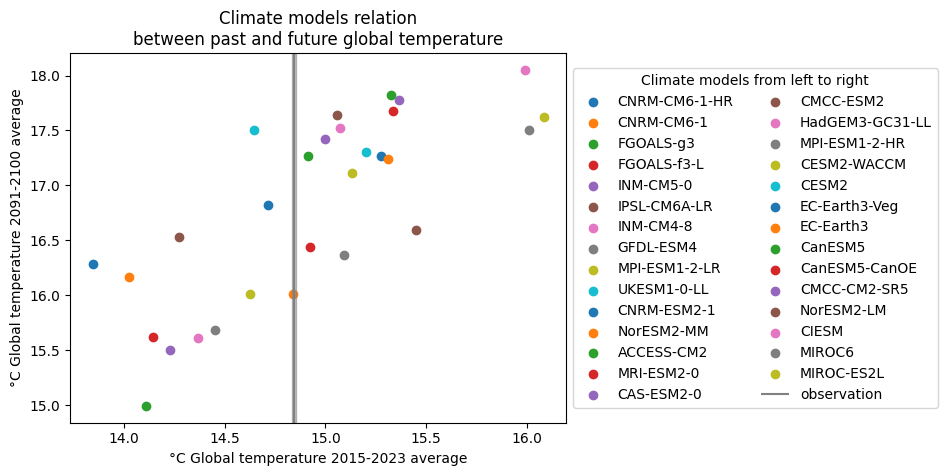

In [10]:
# Display each climate model
for id_model in np.argsort(list_X):
    plt.scatter(list_X[id_model]-273.15, list_Y[id_model]-273.15, label="{}".format(list_models[id_model]))
plt.xlabel("째C Global temperature {}-{} average".format(min_X, max_X))
plt.ylabel("째C Global temperature {}-{} average".format(min_Y, max_Y))

# Display the observation +- uncertainty
ymin, ymax = plt.gca().get_ylim()
plt.vlines(X_obs, ymin, ymax, color='gray', label="observation")
plt.fill_betweenx([ymin, ymax], X_obs-std_obs, X_obs+std_obs, alpha=0.5, color='gray')
plt.ylim(ymin, ymax)

# Editing
plt.legend(ncol=2, bbox_to_anchor=(1, 0.5), loc='center left', title="Climate models from left to right")
plt.title("Climate models relation\nbetween past and future global temperature")
plt.show()

# Save the computed values, to use them in the next notebook

In [11]:
np.save("../data/X_mod", np.array(list_X))
np.save("../data/Y_mod", np.array(list_Y))
np.save("../data/list_runs", np.array(list_runs))
np.save("../data/list_models", np.array(list_models))